# Import packages

In [1]:
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
PATH = "chest-xray-pneumonia\\chest_xray"

# Load data
- Download the data from https://storage.googleapis.com/kaggle-data-sets/17810/23812/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1582451028&Signature=AY2Hf4JBFrGZF%2B1X91rnlUeOw5Z4PBePEvYqt8DdHs2pb%2BNBOCm9FkrVMjmwRNonot2gghGoX5snRVQc9z5ohr9TrDp7iiZ1pXkIJ2gObR6m0tgnXp5D%2FI%2Fh2ZzWfCXIITIosOzGK0La1g4RuZYlLP91mjDmadLRF9oXvFvUe18UE2J5x4tQAm7PAq9oJOt8o4HImQ0QixSC%2BA5Q7sESlmSGgFGtxjSx5Usx3CpyZDzzlGktHICbt6KX3%2B3U6jNBpOPKqAUZeNhGp6ltBtxsJk4%2FEbLaSQ8ilRcG%2FbvpmfqlOMQkNMbKCEBq9bRbawJo1C0gQt%2FKteSewB7gXDon8g%3D%3D&response-content-disposition=attachment%3B+filename%3Dchest-xray-pneumonia.zip

In [3]:
os.listdir(PATH)

['chest_xray', 'test', 'train', 'val', '__MACOSX']

### By using the html link

In [4]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

#### After extracting its contents, assign variables with the proper file path for the training, testing and validation set.

In [5]:
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH,"test")
validation_dir = os.path.join(PATH, 'val')

In [6]:
train_nor_dir = os.path.join(train_dir, 'NORMAL')  # directory with our training NORMAL pictures
train_pne_dir = os.path.join(train_dir, 'PNEUMONIA')  # directory with our training PNEUMONIA pictures
test_nor_dir = os.path.join(test_dir , "NORMAL")  # directory with our testing NORMAL pictures
test_pne_dir = os.path.join(test_dir ,"PNEUMONIA")  # directory with our testing PNEUMONIA pictures
validation_nor_dir = os.path.join(validation_dir, 'NORMAL')  # directory with our validation NORMAL pictures
validation_pne_dir = os.path.join(validation_dir, 'PNEUMONIA')  # directory with our validation PNEUMONIA pictures

In [7]:
num_nor_tr = len(os.listdir(train_nor_dir))
num_pne_tr = len(os.listdir(train_pne_dir))

num_nor_te = len(os.listdir(test_nor_dir))
num_pne_te = len(os.listdir(test_pne_dir))

num_nor_val = len(os.listdir(validation_nor_dir))
num_pne_val = len(os.listdir(validation_pne_dir))

total_train = num_nor_tr + num_pne_tr
total_test = num_nor_te + num_pne_te
total_val = num_nor_val + num_pne_val

# Understand the data

Let's look at how many Normal and Pneumonia images are in the training, testing and validation directory:

In [8]:
print('total training normal images:', num_nor_tr)
print('total training pneumonia images:', num_pne_tr)

print('total testing normal images:', num_nor_te)
print('total testing pneumonia images:', num_pne_te)


print('total validation normal images:', num_nor_val)
print('total validation pneumonia images:', num_pne_val)
print("--")
print("Total training images:", total_train)
print("Total testing images:", total_test)
print("Total validation images:", total_val)

total training normal images: 1341
total training pneumonia images: 3875
total testing normal images: 234
total testing pneumonia images: 390
total validation normal images: 8
total validation pneumonia images: 8
--
Total training images: 5216
Total testing images: 624
Total validation images: 16


For convenience, set up variables to use while pre-processing the dataset and training the network.

In [9]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the ImageDataGenerator class provided by tf.keras. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our testing data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the flow_from_directory method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 5216 images belonging to 2 classes.


In [12]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 624 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 16 images belonging to 2 classes.


# Visualize training images¶

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with matplotlib.

In [14]:
sample_training_images, _ = next(train_data_gen)

The next function returns a batch from the dataset. The return value of next function is in form of (x_train, y_train) where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [15]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

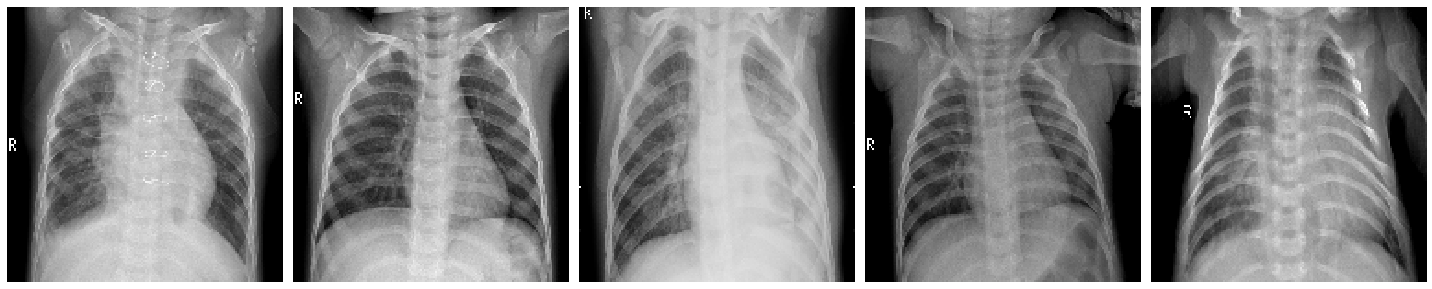

In [16]:
plotImages(sample_training_images[:5])

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu`` activation function.

In [17]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

# Compile the model

For this tutorial, choose the ADAM optimizer and binary cross entropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary

View all the layers of the network using the model's summary method:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

# Train the model

Use the fit_generator method of the ImageDataGenerator class to train the network.

In [20]:
history_train_val = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 1 steps
Epoch 1/15
40/40 [==============================] - 85s 2s/step - loss: 0.4990 - accuracy: 0.7767 - val_loss: 0.4366 - val_accuracy: 0.7500
Epoch 2/15
40/40 [==============================] - 85s 2s/step - loss: 0.1391 - accuracy: 0.9434 - val_loss: 0.6013 - val_accuracy: 0.7500
Epoch 3/15
40/40 [==============================] - 85s 2s/step - loss: 0.0997 - accuracy: 0.9634 - val_loss: 0.4656 - val_accuracy: 0.7500
Epoch 4/15
40/40 [==============================] - 85s 2s/step - loss: 0.0741 - accuracy: 0.9733 - val_loss: 0.5411 - val_accuracy: 0.8125
Epoch 5/15
40/40 [==============================] - 85s 2s/step - loss: 0.0742 - accuracy: 0.9699 - val_loss: 0.4047 - val_accuracy: 0.8750
Epoch 6/15
40/40 [==============================] - 86s 2s/step - loss: 0.0546 - accuracy: 0.9805 - val_loss: 0.1196 - val_accuracy: 

# Visualize training results

Now visualize the results after training the network.

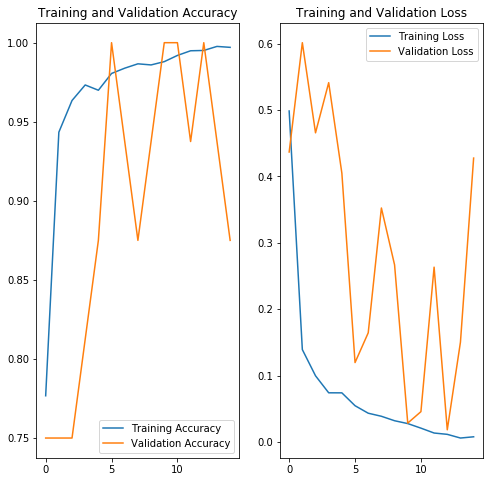

In [28]:
acc = history_train_val.history['accuracy']
val_acc = history_train_val.history['val_accuracy']

loss= history_train_val.history['loss']
val_loss= history_train_val.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Visualize testing results

Now visualize the results after testing the network.

In [22]:
history_train_test = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 4 steps
Epoch 1/15
40/40 [==============================] - 210s 5s/step - loss: 0.0047 - accuracy: 0.9982 - val_loss: 2.8407 - val_accuracy: 0.7383
Epoch 2/15
40/40 [==============================] - 212s 5s/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 2.4684 - val_accuracy: 0.7578
Epoch 3/15
40/40 [==============================] - 211s 5s/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 1.7413 - val_accuracy: 0.7812
Epoch 4/15
40/40 [==============================] - 210s 5s/step - loss: 0.0117 - accuracy: 0.9961 - val_loss: 2.6533 - val_accuracy: 0.7402
Epoch 5/15
40/40 [==============================] - 208s 5s/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 2.7892 - val_accuracy: 0.7441
Epoch 6/15
40/40 [==============================] - 211s 5s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.5730 - val_accuracy: 0.7656
Epoch 7/15
40/40 [==============================] - 209s 5s/ste

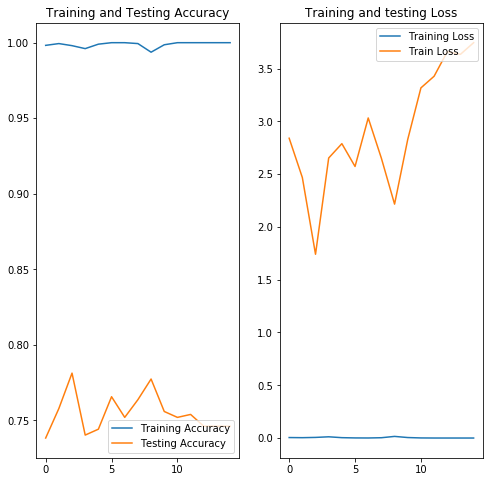

In [27]:
acc = history_train_test.history['accuracy']
val_acc = history_train_test.history['val_accuracy']

loss= history_train_test.history['loss']
val_loss= history_train_test.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Train Loss')
plt.legend(loc='upper right')
plt.title('Training and testing Loss')
plt.show()

In [29]:
history_test_val = model.fit_generator(
    test_data_gen,
    steps_per_epoch=total_test // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4 steps, validate for 1 steps
Epoch 1/15
4/4 [==============================] - 20s 5s/step - loss: 3.0448 - accuracy: 0.6875 - val_loss: 0.4329 - val_accuracy: 0.6250
Epoch 2/15
4/4 [==============================] - 22s 5s/step - loss: 0.5333 - accuracy: 0.7246 - val_loss: 0.3502 - val_accuracy: 1.0000
Epoch 3/15
4/4 [==============================] - 21s 5s/step - loss: 0.5777 - accuracy: 0.6915 - val_loss: 0.5341 - val_accuracy: 0.7500
Epoch 4/15
4/4 [==============================] - 21s 5s/step - loss: 0.4439 - accuracy: 0.7984 - val_loss: 0.3812 - val_accuracy: 0.8750
Epoch 5/15
4/4 [==============================] - 22s 5s/step - loss: 0.3917 - accuracy: 0.8262 - val_loss: 0.4465 - val_accuracy: 0.7500
Epoch 6/15
4/4 [==============================] - 21s 5s/step - loss: 0.3078 - accuracy: 0.8488 - val_loss: 0.5156 - val_accuracy: 0.7500
Epoch 7/15
4/4 [==============================] - 22s 5s/step - loss: 0.2359 - acc

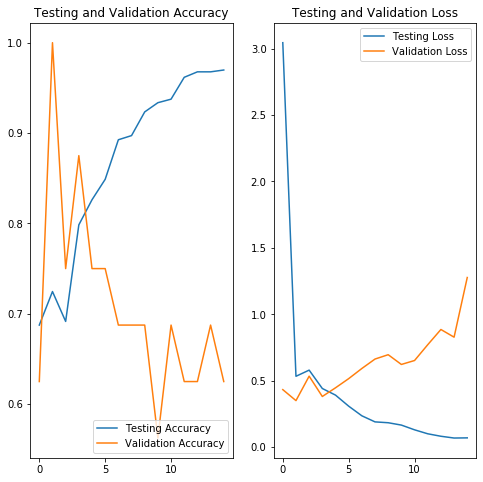

In [30]:
acc = history_test_val.history['accuracy']
val_acc = history_test_val.history['val_accuracy']

loss=history_test_val.history['loss']
val_loss=history_test_val.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Testing Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Testing and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Testing Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Testing and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 70% accuracy on the validation set.

Let's look at what went wrong and try to increase overall performance of the model.

# Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to our model.

# Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in tf.keras using the ImageDataGenerator class. Pass different transformations to the dataset and it will take care of applying it during the training process.

## Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

## Apply horizontal flip¶

Pass horizontal_flip as an argument to the ImageDataGenerator class and set it to True to apply this augmentation.

In [31]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [32]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 5216 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [33]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

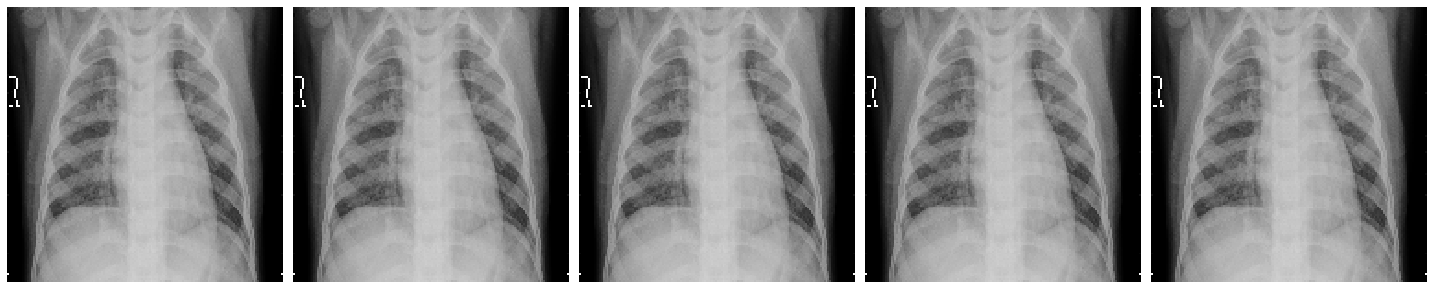

In [34]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

# Randomly rotate the image

Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

In [35]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [36]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 5216 images belonging to 2 classes.


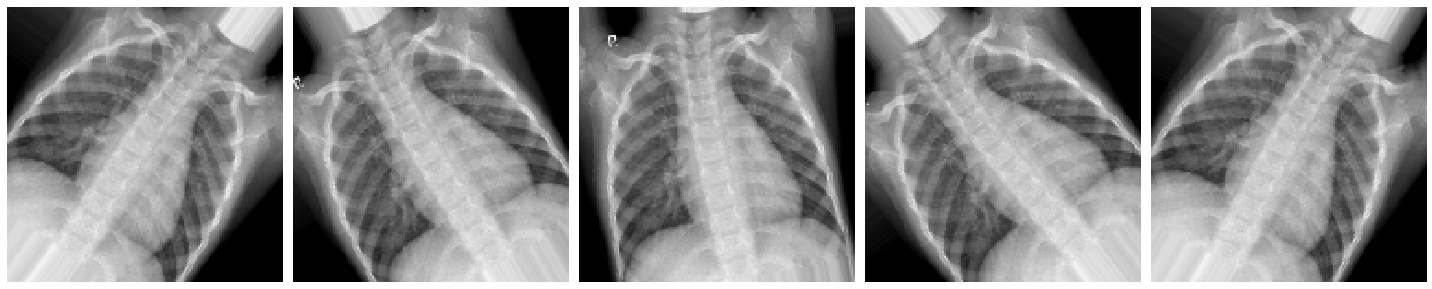

In [37]:
plotImages(augmented_images)

# Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [38]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [39]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 5216 images belonging to 2 classes.


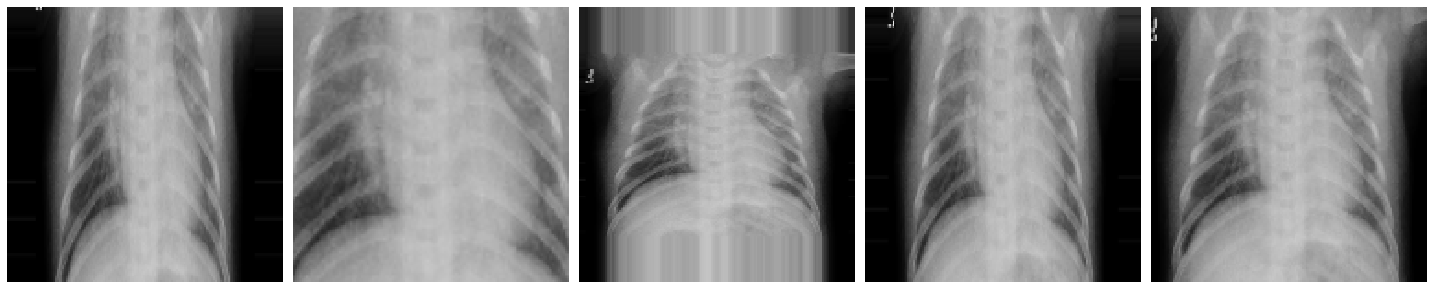

In [40]:
plotImages(augmented_images)

# Put it all together

Apply all the previous augmentations. Here, you applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [42]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5)

In [43]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 5216 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

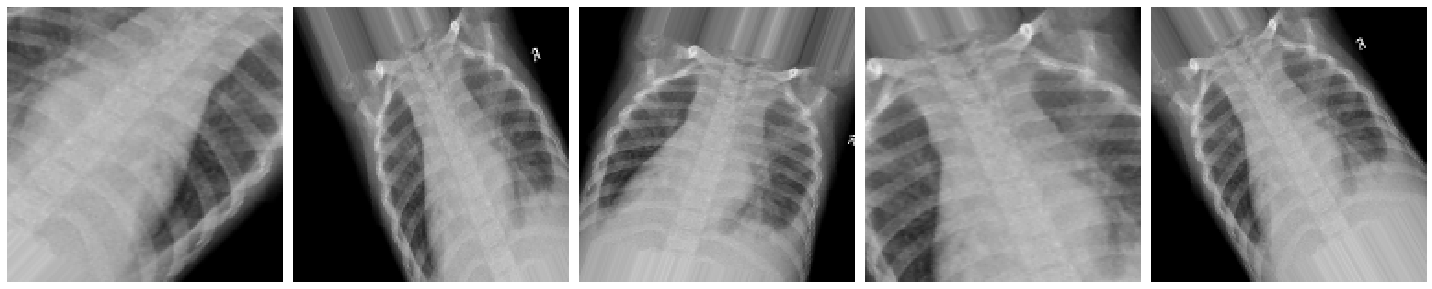

In [45]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using ImageDataGenerator.

In [46]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [47]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 16 images belonging to 2 classes.


# Dropout

Another technique to reduce overfitting is to introduce dropout to the network. It is a form of regularization that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this tutorial

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

# Creating a new network with Dropouts

Here, you apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset.

In [48]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

# Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [49]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

# Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [50]:
history_train_val_aug = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 1 steps
Epoch 1/15
40/40 [==============================] - 110s 3s/step - loss: 0.8042 - accuracy: 0.6602 - val_loss: 0.7423 - val_accuracy: 0.5625
Epoch 2/15
40/40 [==============================] - 107s 3s/step - loss: 0.5639 - accuracy: 0.7374 - val_loss: 0.7186 - val_accuracy: 0.6875
Epoch 3/15
40/40 [==============================] - 107s 3s/step - loss: 0.5067 - accuracy: 0.7640 - val_loss: 1.2256 - val_accuracy: 0.5625
Epoch 4/15
40/40 [==============================] - 107s 3s/step - loss: 0.4303 - accuracy: 0.7928 - val_loss: 1.1768 - val_accuracy: 0.5625
Epoch 5/15
40/40 [==============================] - 107s 3s/step - loss: 0.4026 - accuracy: 0.8096 - val_loss: 1.6165 - val_accuracy: 0.5000
Epoch 6/15
40/40 [==============================] - 107s 3s/step - loss: 0.3490 - accuracy: 0.8408 - val_loss: 2.0174 - val_accuracy: 0.5000
Epoch 7/15
40/40 [==============================] - 107s 3s/ste

# Visualize the model

Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

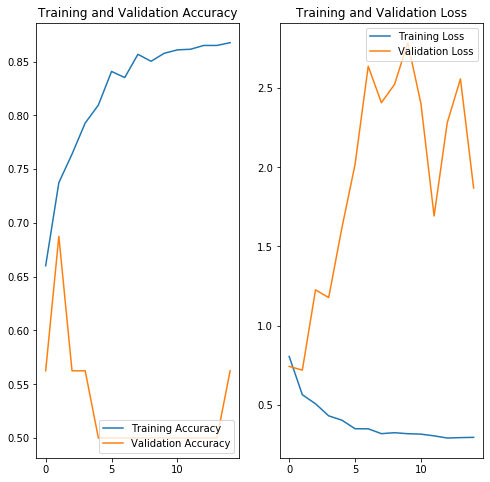

In [51]:
acc = history_train_val_aug.history['accuracy']
val_acc = history_train_val_aug.history['val_accuracy']

loss = history_train_val_aug.history['loss']
val_loss = history_train_val_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()